In [29]:
import os
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

HOLDOUT = 10
R = 0.01
os.chdir("C:\\Users\\USUARIO\\Desktop\\eigenfaces\\PIC-EigenfacesFracionario\\")
os.getcwd()

'C:\\Users\\USUARIO\\Desktop\\eigenfaces\\PIC-EigenfacesFracionario'

In [55]:
def CarregarYaleFaces():
    files = glob.glob("databases/yalefaces/*")
    images_yale = [np.array(imageio.mimread(file))[0] for file in files]
    images_yale_resized = [cv2.resize(image, dsize=(28, 23), interpolation=cv2.INTER_CUBIC) for image in images_yale]
    images_yale_resized = np.array(images_yale_resized)
    images_yale_flatten = [image.flatten() for image in images_yale_resized]
    images_yale_flatten = np.array(images_yale_flatten)
    #print('#Amostras (n): '+str(images_yale_flatten.shape[0]))
    #print('#Features (m): '+str(images_yale_flatten.shape[1]))
    Y = [f.split('.')[0] for f in files]
    return images_yale_flatten, Y

In [56]:
def PCA(X, k):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    #matriz de covariancia m x m
    C = np.zeros((m, m))
    for i in range(n):
        a = X[i].T.reshape(m,1) - mean.T.reshape(m,1)
        b = X[i] - mean
        C = C + (a * b)
    C = 1./n * C
    val, vec = np.linalg.eig(C)
    X_ = vec.T.dot((X - mean).T)
    return X_.T[:,:k]

In [57]:
def FPCA(X, k, r):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    mean = np.power(mean, r)
    X = np.power(X, r)
    #matriz de covariancia m x m
    C = np.zeros((m, m))
    for i in range(n):
        a = X[i].T.reshape(m,1) - mean.T.reshape(m,1)
        b = X[i] - mean
        C = C + (a * b)
    C = 1./n * C
    val, vec = np.linalg.eig(C)
    X_ = vec.T.dot((X - mean).T)
    return X_.T[:,:k]

In [58]:
def Eigenfaces(X, k):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    D = np.zeros((n, n))
    for j in range(m):
        a = X[:,j] - X[:,j].mean()
        a = a.reshape(n,1)
        b = a.T
        D = D + (a * b)
    val, vec = np.linalg.eig(D)
    val = np.abs(val)
    vec_c = 1. / np.power((n * val), 0.5) #eq 7
    vec_c = vec_c * (X - mean).T.dot(vec) #eq 7
    X_ = vec_c.T.dot((X - mean).T)
    return X_.T[:,:k]

In [59]:
def F_Eigenfaces(X, k, r):
    n = X.shape[0]
    m = X.shape[1]
    mean = np.mean(X, axis = 0)
    D = np.zeros((n, n))
    for j in range(m):
        a = np.power(X[:,j], r) - np.power(X[:,j].mean(), r)
        a = a.reshape(n,1)
        b = a.T
        D = D + (a * b)
    val, vec = np.linalg.eig(D)
    val = np.abs(val)
    vec_c = 1. / np.power((n * val), 0.5)
    vec_c = vec_c * (np.power(X, r) - np.power(mean,r)).T.dot(vec)
    X_ = vec_c.T.dot((np.power(X,r) - np.power(mean,r)).T)
    return X_.T[:,:k]

In [60]:
def AvaliarClassificadores(X, Y):
    scores_1nn = []
    
    for i in range(HOLDOUT):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
        clf_1nn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
        scores_1nn.append(clf_1nn.score(X_test, y_test))

    scores_1nn = np.array(scores_1nn).mean() * 100
    return scores_1nn

In [61]:
images_yale, Y = CarregarYaleFaces()
acc_yale = []
acc_att = []
acc_sheffield = []
for n in range(1, 71):
    X_pca  = PCA(images_yale, n)
    X_fpca = FPCA(images_yale, n, R)
    X_eige = Eigenfaces(images_yale, n)
    X_feig = F_Eigenfaces(images_yale, n, R)
    s_pca  = AvaliarClassificadores(X_pca, Y)
    s_fpca = AvaliarClassificadores(X_fpca, Y)
    s_eige = AvaliarClassificadores(X_eige, Y)
    s_feig = AvaliarClassificadores(X_feig, Y)
    acc_yale.append([s_pca,s_fpca,s_eige,s_feig])
acc_yale = np.array(acc_yale)

C:\Users\USUARIO\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


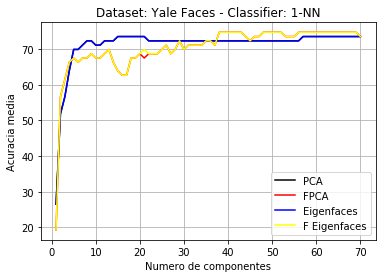

In [66]:
x = np.arange(1, 71)
#plt.figure(figsize=(20,15))
plt.title("Dataset: Yale Faces - Classifier: 1-NN")
plt.plot(x, acc_yale[:,0], color='black')
plt.plot(x, acc_yale[:,1], color='red')
plt.plot(x, acc_yale[:,2], color='blue')
plt.plot(x, acc_yale[:,3], color='yellow')
plt.ylabel('Acuracia media')
plt.xlabel('Numero de componentes')
plt.legend(labels=['PCA','FPCA','Eigenfaces','F Eigenfaces'])
plt.grid()
plt.show()